# Homework #3: Clustering and Trees

* This specific response to assignment uses the student's credit card transaction data over the last 24 months, before the reality of owning a mortgage kicked-in. 
* The dataset reveals sensitive information so exposure of all rows have been sparingly done, if at all.
* The dataset has been manipulated to reveal high-level location info e.g. Australia vs overseas; and the type of expense e.g. Utility, Education, Retail Shopping.
* As the most unpredictable of all expense types falls under RETAIL SHOPPING, transactions that fall under this category have been filtered and used for a number of models discussed in this submission, to reveal the factors, if any, that drive the subject's RETAIL SHOPPING habit.

## Part1. Data Acquisition and Wrangling

In [1]:
# Import the libraries needed
import sklearn.linear_model
import pandas
import matplotlib.pyplot

In [2]:
#Inhale the credit card transaction log.
cardtrans = pandas.read_csv('C:\Users\Celeste\Desktop\GA Data Science\SYD_DAT_7\HW2_Celeste\data\All_Credit_Card_Log_01Mar2015_27Feb2017.csv', index_col=0)
cardtrans.head(3)

,DATE,AMOUNT,DESC,CATEGORY,LOCATION
#,,,,,
1105,11/11/2015,-22.0,200 RTA INTERNET /IVR SURRY HILLS,CAR,AUSTRALIA
1409,16/06/2015,-147.0,200 RTA INTERNET /IVR SURRY HILLS,CAR,AUSTRALIA
479,27/07/2016,-778.0,2NDS WORLD AUBURN NSW,HOME,AUSTRALIA


In [3]:
cardtrans.count()

DATE        1650
AMOUNT      1650
DESC        1650
CATEGORY    1650
LOCATION    1650
dtype: int64

In [4]:
# Get rid of DEBIT transactions such as Credit Card Bills Payment and Shopping Refunds
# Aim: To ensure data is strictly about EXPENDITURE, excluding Refund or Card Payments.
cardtrans = cardtrans[cardtrans.AMOUNT <= 0]
cardtrans.head(3)

,DATE,AMOUNT,DESC,CATEGORY,LOCATION
#,,,,,
1105,11/11/2015,-22.0,200 RTA INTERNET /IVR SURRY HILLS,CAR,AUSTRALIA
1409,16/06/2015,-147.0,200 RTA INTERNET /IVR SURRY HILLS,CAR,AUSTRALIA
479,27/07/2016,-778.0,2NDS WORLD AUBURN NSW,HOME,AUSTRALIA


In [5]:
cardtrans.dtypes

DATE         object
AMOUNT      float64
DESC         object
CATEGORY     object
LOCATION     object
dtype: object

In [6]:
# oops, need to deal with incorrect data types
cardtrans['DATE'] = pandas.to_datetime(cardtrans['DATE'])
cardtrans.head(3)

,DATE,AMOUNT,DESC,CATEGORY,LOCATION
#,,,,,
1105,2015-11-11,-22.0,200 RTA INTERNET /IVR SURRY HILLS,CAR,AUSTRALIA
1409,2015-06-16,-147.0,200 RTA INTERNET /IVR SURRY HILLS,CAR,AUSTRALIA
479,2016-07-27,-778.0,2NDS WORLD AUBURN NSW,HOME,AUSTRALIA


In [7]:
cardtrans.dtypes

DATE        datetime64[ns]
AMOUNT             float64
DESC                object
CATEGORY            object
LOCATION            object
dtype: object

In [8]:
# Add a new column to reflect absolute value of Amount Spent
cardtrans['ABS_AMOUNT'] = cardtrans.AMOUNT * -1.00

In [9]:
cardtrans.describe()

,AMOUNT,ABS_AMOUNT
count,1571.000000,1571.000000
mean,-53.470707,53.470707
std,155.841402,155.841402
min,-3075.280000,0.240000
25%,-49.475000,8.500000
50%,-20.000000,20.000000
75%,-8.500000,49.475000
max,-0.240000,3075.280000


In [10]:
#Include retail shopping only, exclude : regular bills, annual fee, international transaction fee, utility
retail_trans = cardtrans[(cardtrans.CATEGORY=='RETAIL')]
retail_trans = retail_trans[retail_trans.DESC!='ANNUAL FEE']
retail_trans = retail_trans[retail_trans.DESC!='INTNL TRANSACTION FEE']
retail_trans.describe()


,AMOUNT,ABS_AMOUNT
count,248.000000,248.000000
mean,-71.558468,71.558468
std,127.445651,127.445651
min,-1167.110000,2.000000
25%,-72.470000,18.367500
50%,-34.180000,34.180000
75%,-18.367500,72.470000
max,-2.000000,1167.110000


In [11]:
retail_trans.LOCATION.unique()

array(['JAPAN', 'AUSTRALIA', 'AUSTRALIA-MELBOURNE', 'VIETNAM',
       'AUSTRALIA-BLUE MTNS', 'AUSTRALIA-ECHUCA'], dtype=object)

In [12]:
#Transaction Distribution by LOCATION
retail_trans.LOCATION.value_counts()

AUSTRALIA              181
JAPAN                   59
AUSTRALIA-BLUE MTNS      4
VIETNAM                  2
AUSTRALIA-MELBOURNE      1
AUSTRALIA-ECHUCA         1
Name: LOCATION, dtype: int64

In [13]:
#Transaction Distribution by CATEGORY
retail_trans.CATEGORY.value_counts()

RETAIL    248
Name: CATEGORY, dtype: int64

In [14]:
# Define dictionary for Holiday Flag, set to:
    # 2 if location is a INTERNATIONAL HOLIDAY LOCATION
    # 1 if location is a DOMESTIC HOLIDAY LOCATION
    # 0 if NON-HOLIDAY.
hols_dict ={'AUSTRALIA':0,'VIETNAM':2, 'AUSTRALIA-PORT DOUGLAS':1,
           'AUSTRALIA-BLUE MTNS':1, 'AUSTRALIA-ECHUCA':1, 'AUSTRALIA-MELBOURNE':1,
           'AUSTRALIA-BENDIGO':1, 'JAPAN':2, 'AUSTRALIA-SUNSHINE COAST':1 }
hols_dict

{'AUSTRALIA': 0,
 'AUSTRALIA-BENDIGO': 1,
 'AUSTRALIA-BLUE MTNS': 1,
 'AUSTRALIA-ECHUCA': 1,
 'AUSTRALIA-MELBOURNE': 1,
 'AUSTRALIA-PORT DOUGLAS': 1,
 'AUSTRALIA-SUNSHINE COAST': 1,
 'JAPAN': 2,
 'VIETNAM': 2}

In [15]:
# Create a new column in the "cardtrans" data frame calling cardtrans.LOCATION.map() with 
# my hols_dict dictionary as an argument
retail_trans['HOLIDAY_FLAG'] = retail_trans.LOCATION.map(hols_dict.get)
retail_trans.HOLIDAY_FLAG.value_counts()

0    181
2     61
1      6
Name: HOLIDAY_FLAG, dtype: int64

In [16]:
retail_trans.head(3)

,DATE,AMOUNT,DESC,CATEGORY,LOCATION,ABS_AMOUNT,HOLIDAY_FLAG
#,,,,,,,
1013,2015-12-19,-26.14,ABAB UENO TOUKIYOUTO JPN ##121...,RETAIL,JAPAN,26.14,2
1001,2015-12-22,-110.91,ABAB UENO TOUKIYOUTO JPN ##121...,RETAIL,JAPAN,110.91,2
129,2016-12-26,-207.57,ADAIRS BENDIGO BENDIGO,RETAIL,AUSTRALIA,207.57,0


In [17]:
# In case the day of the week or the month of the year play particular role in my retail shopping expenditure,
# I'd like to add these two fields (1) Day of the Week; and (2) Month of the Year.

#(1) DayOfTheWeek:
#0: Mon
#1: Tue
#2: Wed
#3: Thu
#4: Fri
#5: Sat
#6: Sun

#(2) MonthOfYear:
#1: Jan
#2: Feb....
#12: Dec

retail_trans['DayOfTheWk']=retail_trans.DATE.dt.dayofweek
retail_trans['MonthOfYear']=retail_trans.DATE.dt.month
retail_trans = retail_trans.sort(['DATE', 'ABS_AMOUNT'], ascending=[0, 0])
retail_trans.head(3)

C:\Users\Celeste\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,DATE,AMOUNT,DESC,CATEGORY,LOCATION,ABS_AMOUNT,HOLIDAY_FLAG,DayOfTheWk,MonthOfYear
#,,,,,,,,,
55,2017-03-02,-59.00,iKOU Sydney NSW,RETAIL,AUSTRALIA,59.00,0,3,3
56,2017-03-02,-20.98,LOVISA PTY LTD SYDNEY,RETAIL,AUSTRALIA,20.98,0,3,3
8,2017-02-18,-93.50,LINDUS HORNSBY HORNSBY,RETAIL,AUSTRALIA,93.50,0,5,2


In [18]:
retail_trans.describe()

,AMOUNT,ABS_AMOUNT,HOLIDAY_FLAG,DayOfTheWk,MonthOfYear
count,248.000000,248.000000,248.000000,248.000000,248.000000
mean,-71.558468,71.558468,0.516129,3.233871,6.870968
std,127.445651,127.445651,0.862947,2.091467,3.590288
min,-1167.110000,2.000000,0.000000,0.000000,1.000000
25%,-72.470000,18.367500,0.000000,1.000000,4.000000
50%,-34.180000,34.180000,0.000000,4.000000,6.000000
75%,-18.367500,72.470000,1.000000,5.000000,10.250000
max,-2.000000,1167.110000,2.000000,6.000000,12.000000


In [19]:
# I'd also like to add a field called Expense Level where Expense Level is:
# 0: if the amount spent is less than or equal to the MEAN of ABS_AMOUNT (see above);
# 1: if the amount spent is >MEAN and <= MEAN + 1 StDev of ABS_AMOUNT (see above);
# 2: if the amount spent is >MEAN + 1 StDev and <= MEAN + 2 StDev of ABS_AMOUNT (see above);
# 3: if the amount spent is >MEAN + 2 StDev and <= MEAN + 3 StDev of ABS_AMOUNT (see above);
# 4: if the amount spent is >MEAN + 3 StDev(see above);

retail_trans['Expense_Level']=0
retail_trans['Expense_Level'][retail_trans['ABS_AMOUNT'] <= 72.0]=0
retail_trans['Expense_Level'][(retail_trans['ABS_AMOUNT'] > 72.0) & (retail_trans['ABS_AMOUNT'] <= 199.0)]=1
retail_trans['Expense_Level'][(retail_trans['ABS_AMOUNT'] > 199.0) & (retail_trans['ABS_AMOUNT'] <= 326.0)]=2
retail_trans['Expense_Level'][(retail_trans['ABS_AMOUNT'] > 326.0) & (retail_trans['ABS_AMOUNT'] <= 453.0)]=3
retail_trans['Expense_Level'][retail_trans['ABS_AMOUNT'] > 453.0]=4
retail_trans.head(5)

C:\Users\Celeste\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Celeste\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Celeste\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Celeste\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,DATE,AMOUNT,DESC,CATEGORY,LOCATION,ABS_AMOUNT,HOLIDAY_FLAG,DayOfTheWk,MonthOfYear,Expense_Level
#,,,,,,,,,,
55,2017-03-02,-59.00,iKOU Sydney NSW,RETAIL,AUSTRALIA,59.00,0,3,3,0
56,2017-03-02,-20.98,LOVISA PTY LTD SYDNEY,RETAIL,AUSTRALIA,20.98,0,3,3,0
8,2017-02-18,-93.50,LINDUS HORNSBY HORNSBY,RETAIL,AUSTRALIA,93.50,0,5,2,1
7,2017-02-18,-39.00,MYER HORNSBY HORNSBY NSW,RETAIL,AUSTRALIA,39.00,0,5,2,0
21,2017-02-13,-326.86,MODCLOTH 8884959699 CA ##0217...,RETAIL,AUSTRALIA,326.86,0,0,2,3


## Part 2: Clustering
* For this specific example, I think I can use the following categories:
    * ABS_AMOUNT
    * DayOfTheWk
    * Holiday_Flag; and 
    * MonthOfYear 
... where clustering can be successful.

In [20]:
import sklearn.cluster
import matplotlib.pyplot
import numpy

In [21]:
# turning the dataframe into an array
retail_trans_tmp=retail_trans[['ABS_AMOUNT','DayOfTheWk','HOLIDAY_FLAG','MonthOfYear']]
retail_trans_array=retail_trans_tmp.values
retail_trans_array

array([[  5.90000000e+01,   3.00000000e+00,   0.00000000e+00,
          3.00000000e+00],
       [  2.09800000e+01,   3.00000000e+00,   0.00000000e+00,
          3.00000000e+00],
       [  9.35000000e+01,   5.00000000e+00,   0.00000000e+00,
          2.00000000e+00],
       [  3.90000000e+01,   5.00000000e+00,   0.00000000e+00,
          2.00000000e+00],
       [  3.26860000e+02,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00],
       [  3.00000000e+01,   6.00000000e+00,   0.00000000e+00,
          1.00000000e+00],
       [  2.50000000e+01,   5.00000000e+00,   0.00000000e+00,
          1.00000000e+00],
       [  1.35000000e+01,   5.00000000e+00,   0.00000000e+00,
          1.00000000e+00],
       [  4.00000000e+00,   5.00000000e+00,   0.00000000e+00,
          1.00000000e+00],
       [  1.20950000e+02,   3.00000000e+00,   0.00000000e+00,
          1.20000000e+01],
       [  2.07570000e+02,   0.00000000e+00,   0.00000000e+00,
          1.20000000e+01],
       [  3.36900000e

### PART 2a. Preparing KMeans Clustering for my initial trial: N_clusters =5

In [22]:
clusterer5 = sklearn.cluster.KMeans(n_clusters=5)
clusterer5_suggestions = clusterer5.fit_predict(retail_trans_array)
clusterer5_suggestions

array([3, 1, 3, 1, 0, 1, 1, 1, 1, 3, 0, 1, 1, 3, 3, 1, 0, 1, 3, 2, 1, 1, 3,
       1, 0, 1, 0, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 0,
       1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 0, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 2, 2, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 2, 3, 1, 1, 1, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 0, 1, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 0, 3, 1, 3, 3, 1, 2, 3, 3, 3, 1,
       1, 1, 3, 0, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1,
       1, 0, 1, 1, 3, 1, 1, 4, 1, 0, 0, 0, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])

In [23]:
# seeing what the Silhouette Score might look like
import sklearn.metrics
sklearn.metrics.silhouette_score(retail_trans_array, clusterer5_suggestions)

0.63581340316141921

### PART 2b. Preparing KMeans Clustering for a variety of Cluster Counts: 2 to 21

In [24]:
# Seeing what the Silhouette Scores will look like in various Cluster Counts : 2 through to 21
scores = []
for i in range(2, 21):
    clustereri = sklearn.cluster.KMeans(n_clusters=i)
    cluster_suggestionsi = clustereri.fit_predict(retail_trans_array)
    scores.append(sklearn.metrics.silhouette_score(retail_trans_array, cluster_suggestionsi))
scores

[0.9068526360489656,
 0.71506442655725633,
 0.71746085001196591,
 0.63581340316141921,
 0.64630450773480075,
 0.57387991858812759,
 0.55096375284967425,
 0.5105407853745364,
 0.50780581508753742,
 0.44605324958892528,
 0.46272547136588965,
 0.4528992287302579,
 0.45879596201955314,
 0.42541829212591942,
 0.41966662288006895,
 0.42536774629472046,
 0.40790369517567948,
 0.40214194264223901,
 0.38082915707940357]

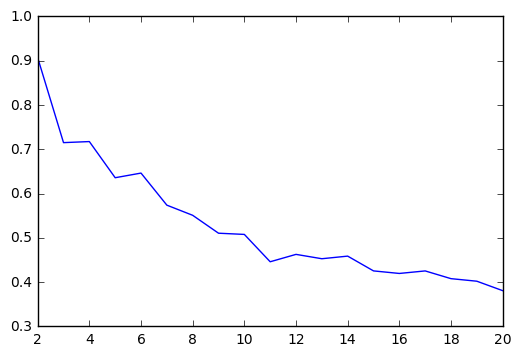

In [25]:
# Plotting how the different Silhouette Scores look like in various Cluster Counts : 2 through to 21
%matplotlib inline
import matplotlib
matplotlib.pyplot.plot(range(2,21), scores)

In [26]:
# According to the Silhouette Scores Plot, it seems that Cluster=2 is where the elbow is, therefore Use: 2 Clusters
clusterer2 = sklearn.cluster.KMeans(n_clusters=2)
cluster_suggestions2 = clusterer2.fit_predict(retail_trans_array)
cluster_suggestions2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
clusterer2.cluster_centers_

array([[  5.44650413e+01,   3.22314050e+00,   4.95867769e-01,
          6.78512397e+00],
       [  7.60993333e+02,   3.66666667e+00,   1.33333333e+00,
          1.03333333e+01]])

### PART 2c. Giving Descriptive Names to the Clusters I've Found

##### Given result of K_Means (with cluster=2), this means the two cluster centres sit around:
* Cluster Centre 0: Avg Spend of 54.47AUD, on Thu, during non-holiday, between June and July; and
* Cluster Centre 1: Avg Spend of 760.99AUD, on bet Thu and Friday, during domestic or international holiday in October.
    
##### As such, I would like to give the following "descriptive names" for the two clusters I've found:
* Cluster 0: "EOFY (End of Financial Year) Thurs late night, mini-shopping spree, after work"; and 
* Cluster 1: "Spring (October) weekend-away retail therapy".

In [28]:
#Plotting x=ABS_AMOUNT Spent with the y=Dayof the Week
x = retail_trans_array[:,0]
y = retail_trans_array[:,1]

In [29]:
#set yellow for cluster#0
#set black for cluster#1
import numpy
colouring = numpy.array(['yellow', 'black'])

In [30]:
colour_by_cluster2 = colouring[cluster_suggestions2]
colour_by_cluster2

array(['yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'black', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',
       'yellow', 'yellow', 'yellow', 'yellow', 'yello

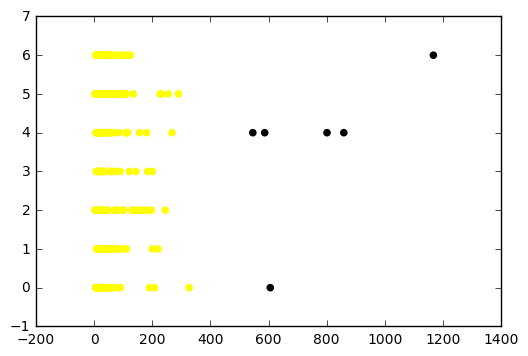

In [31]:
%matplotlib inline
matplotlib.pyplot.scatter(x,y, color=colour_by_cluster2)

### PART 2d. Trying the DBSCAN Clusterer, with eps=4.0 and min_samples=5

In [32]:
# Note: eps is the radius at any direction; If the eps is so small, it is likely to get lots of outliers,
#            so expand the eps value to allow for more points to catch
dbscan = sklearn.cluster.DBSCAN(eps=4.0, min_samples=5)
dbscan_suggestions = dbscan.fit_predict(retail_trans_array)
dbscan_suggestions
sklearn.metrics.silhouette_score(retail_trans_array, dbscan_suggestions)

-0.18459057680728971

### PART 2e. Trying the DBSCAN Clusterer, with eps=10.0 and min_samples=5

In [33]:
# Note: eps is the radius at any direction; If the eps is so small, it is likely to get lots of outliers,
#            so expand the eps value to allow for more points to catch
dbscan = sklearn.cluster.DBSCAN(eps=10.0, min_samples=5)
dbscan_suggestions = dbscan.fit_predict(retail_trans_array)
dbscan_suggestions
sklearn.metrics.silhouette_score(retail_trans_array, dbscan_suggestions)

0.77413541338501468

### PART 2f. Trying the DBSCAN Clusterer, with for eps between 2.0 and 20.0 to see where the "elbow occurs"

In [34]:
# eps=4.0 vs eps=10.0 rendered two very different silhouette scores!
# Notes has it that the higher the Silhouette Score the better so now, I'd like to try for 
# various values of eps between 2.0 and 20.0

# Seeing what the Silhouette Scores will look like for eps: 2.0 through to 20.0
dbscan_scores = []
for i in range(2, 20):
    j=["%.2f" % (i,)]
    dbscan_i = sklearn.cluster.DBSCAN(eps=j, min_samples=5)
    dbscan_cluster_suggestions_i = dbscan_i.fit_predict(retail_trans_array)
    dbscan_scores.append(sklearn.metrics.silhouette_score(retail_trans_array, dbscan_cluster_suggestions_i))
dbscan_scores

[-0.49198460041460779,
 -0.2374540040656008,
 -0.18459057680728971,
 0.31042357865233905,
 0.42230461523266594,
 0.48382169055500085,
 0.75945266419007695,
 0.76457177785620967,
 0.77413541338501468,
 0.63685747312077512,
 0.63890642053011659,
 0.64223069013819667,
 0.84443763290129881,
 0.84443763290129881,
 0.84443763290129881,
 0.84443763290129881,
 0.84443763290129881,
 0.84443763290129881]

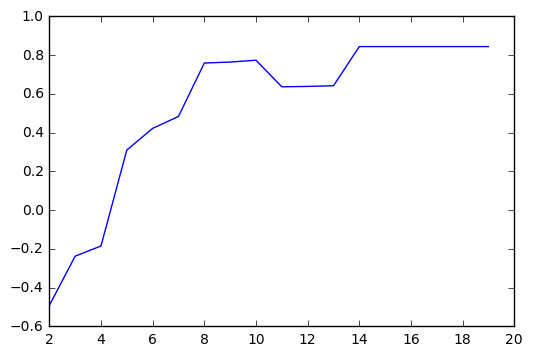

In [35]:
# Plotting how the different Silhouette Scores look like in various eps values : 2.0 through to 20.0
%matplotlib inline
import matplotlib
matplotlib.pyplot.plot(range(2,20), dbscan_scores)     

In [36]:
# by the looks of this, eps=5.0 seems to be the last elbow where significant gains in Silhouette Score appeared
dbscan_clusterer5 = sklearn.cluster.DBSCAN(eps=5.0, min_samples=5)
dbscan_cluster_suggestions5 = dbscan_clusterer5.fit_predict(retail_trans_array)
dbscan_cluster_suggestions5

array([ 0,  1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  2,  2,  1, -1,
        1,  2, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,
        1,  1, -1,  0,  1,  1,  1,  1,  1,  0,  1, -1,  1,  1,  1,  1,  1,
        0,  0,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        0,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1, -1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1, -1,
        1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,
        1,  1,  1,  1, -1,  1,  0,  0,  1,  1,  1,  1, -1,  1,  2,  2, -1,
        2, -1,  1,  1,  1,  1,  2,  0,  0,  1,  1,  1,  0,  1, -1,  2,  1,
        0, -1,  1, -1, -1,  2,  2,  1,  1,  1,  0, -1,  1,  1,  1,  1,  0,
        1,  1,  0,  1,  1,  1,  1,  1,  1,  1, -1,  0,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  0,  1,  0,
        1,  1,  1,  1, -1,  1,  1,  0,  1,  1, -1,  1, -1, -1, -1, -1,  1,
        1,  1, -1,  0,  1

In [37]:
clusterer5.cluster_centers_

array([[  2.11715500e+02,   2.60000000e+00,   5.00000000e-01,
          7.35000000e+00],
       [  2.34961111e+01,   3.27160494e+00,   5.06172840e-01,
          6.45061728e+00],
       [  6.79770000e+02,   3.20000000e+00,   1.20000000e+00,
          1.14000000e+01],
       [  8.56643333e+01,   3.30000000e+00,   4.66666667e-01,
          7.50000000e+00],
       [  1.16711000e+03,   6.00000000e+00,   2.00000000e+00,
          5.00000000e+00]])

### PART 2g. Giving Descriptive Names to the DBSCAN Clusters I've Found

##### Given result of DBSCAN (with eps=5.0), this means the five cluster centres sit around:
* Cluster Centre 0: Avg Spend of  24AUD, on Thu, during non-holiday, in early part of June;
* Cluster Centre 1: Avg Spend of 942AUD, between Fri and Sat, during an international holiday in Sep.
* Cluster Centre 2: Avg Spend of 215AUD, on Wed, during non-holiday in July.
* Cluster Centre 3: Avg Spend of  89.50AUD, on Thu, during non-holiday in July.
* Cluster Centre 4: Avg Spend of 580AUD, on Wed, during non-holiday in November.
    
##### As such, I would like to give the following "descriptive names" for the five DBSCAN clusters I've found:
* Cluster Centre 0: Small purchase, EOFY sale late-night shopping after-work. 
* Cluster Centre 1: Pre-flight weekend splurge before coming home from International Holiday.
* Cluster Centre 2: Medium purchase, EOFY sale, mid-week shopping after-work. 
* Cluster Centre 3: Controlled Splurge, EOFY sale, late-night shopping after-work.
* Cluster Centre 4: Pre-Christmas Splurge, mid-week splurge after-work.


In [38]:
#Plotting x=ABS_AMOUNT Spent with the y=Day of the Week
x5 = retail_trans_array[:,0]
y5 = retail_trans_array[:,1]

In [39]:
#set 'Red' for Cluster: 0
#set 'Orange' for Cluster: 1
#set 'Yellow' for Cluster: 2
#set 'Green' for Cluster: 3
#set 'Black' for Cluster: 4
import numpy
colouring5 = numpy.array(['red','orange','yellow','pink','blue'])

In [40]:
colour_by_cluster5 = colouring5[dbscan_cluster_suggestions5]
colour_by_cluster5

array(['red', 'orange', 'blue', 'orange', 'blue', 'orange', 'orange',
       'orange', 'orange', 'blue', 'blue', 'orange', 'orange', 'yellow',
       'yellow', 'orange', 'blue', 'orange', 'yellow', 'blue', 'orange',
       'orange', 'blue', 'orange', 'blue', 'orange', 'blue', 'orange',
       'blue', 'orange', 'orange', 'blue', 'orange', 'orange', 'orange',
       'orange', 'blue', 'red', 'orange', 'orange', 'orange', 'orange',
       'orange', 'red', 'orange', 'blue', 'orange', 'orange', 'orange',
       'orange', 'orange', 'red', 'red', 'orange', 'orange', 'orange',
       'yellow', 'orange', 'orange', 'orange', 'orange', 'orange',
       'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'red',
       'orange', 'orange', 'blue', 'blue', 'orange', 'orange', 'orange',
       'blue', 'blue', 'orange', 'orange', 'blue', 'orange', 'orange',
       'blue', 'orange', 'orange', 'orange', 'blue', 'orange', 'orange',
       'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'o

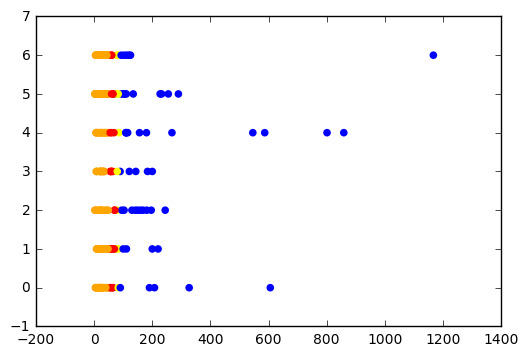

In [41]:
%matplotlib inline
matplotlib.pyplot.scatter(x5,y5, color=colour_by_cluster5)

## Part 3: Decision Trees

In [42]:
import sklearn.tree
import sklearn.grid_search

In [43]:
# Create a DecisionTreeClassifier which splits based on 
# entropy with a depth of 2
dtc = sklearn.tree.DecisionTreeClassifier(max_depth=2, criterion='entropy')

In [44]:
# Try to predict the 'Expense Level' column from 'DayOfTheWk', 'HOLIDAY_FLAG' and 'MonthOfYear'
X=retail_trans[['DayOfTheWk', 'HOLIDAY_FLAG', 'MonthOfYear']]
y=retail_trans.Expense_Level
dtc.fit(X, y)
dtc

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [45]:
# Use the feature_importances_ to identify what was the most important criteria in Expense_Level
dtc.feature_importances_

array([ 0.46500724,  0.        ,  0.53499276])

#### Insights Drawn:

* Month of the Year, followed by the Day of The Week seems to be the two most important drivers of Expense Level
* WHERE "Expense_Level" is:
    * 0: if the amount spent in a day is <=72 AUD; OR MEAN of ABS_AMOUNT ;
    * 1: if the amount spent in a day is between 72.01 and 199 AUD; OR MEAN + 1 StDev of ABS_AMOUNT ;
    * 2: if the amount spent in a day is between 199.01 and 326 AUD; OR MEAN + 2 StDev of ABS_AMOUNT ;
    * 3: if the amount spent in a day is between 326.01 and 453 AUD; OR MEAN + 3 StDev of ABS_AMOUNT ;
    * 4: if the amount spent is > 453 AUD.

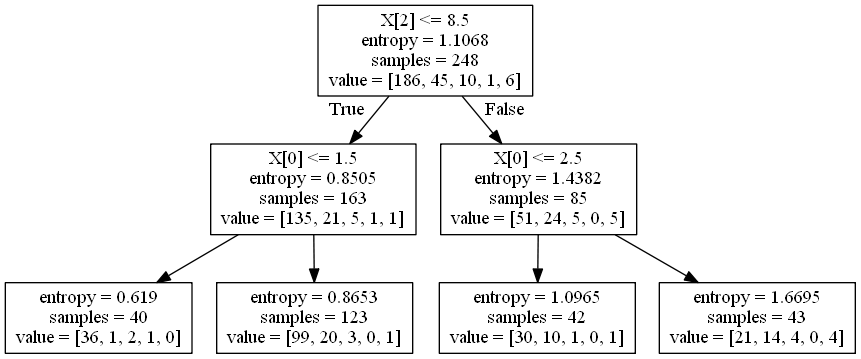

In [46]:
# import the sklearn.tree library and use the export_graphviz
# method to write deeper decision tree out to the StringIO
# file object

try:
 from StringIO import StringIO
except ImportError:
 from io import StringIO

import sklearn.tree
import IPython.display
import pydot
File_obj = StringIO()
sklearn.tree.export_graphviz(dtc, out_file=File_obj)
Graph = pydot.graph_from_dot_data(File_obj.getvalue())
IPython.display.Image(Graph.create_png())

#### Explanation:
* I'd like to use a simple Decision Tree with a depth=2 to articulate the answer to "How certain observable factors affect my retail shopping habit?". The concept alone can get quite overwheliming so as a starting point, I'd start simple. We can refine this later on (for higher levels of accuracy) if needed be.

#### Insights Drawn:
* Decision Tree tells me that it is most likely to :
    * Spend lots on small transactions, <AUD72 between Jan and mid-August, between Monday and Tuesday;
    * Splurge between August and December, between Wednesday and Sunday (probably because of tax rebates, bonus and Christmas)

## Part 4: Model Evaluation

In [47]:
#Defining the prediction variables

X = retail_trans[['DayOfTheWk', 'HOLIDAY_FLAG', 'MonthOfYear']]
y = retail_trans.Expense_Level

In [48]:
retail_trans.shape

(248, 10)

In [49]:
# import the sklearn.cross_validation library
import sklearn.cross_validation

### Part 4a: Model Evaluation using Train-Test-Split of 75% Training-25% Test sample size.

In [50]:
# Split the data into training and testing sets using train_test_split, with 75% training and 25% test size.
from sklearn.cross_validation import train_test_split
import sklearn.metrics
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                              test_size=0.25)

In [51]:
# Training a Logistic Reg Predictor on the Training Data
import sklearn.linear_model
Predictor = sklearn.linear_model.LogisticRegression(C=1000)
Predictor.fit(X_train, y_train)
Y_predict = Predictor.predict(X_test)

# Comparing the accuracy score between y_test (teacher's answer) vs Y_predict (my answer)
print sklearn.metrics.accuracy_score(y_test, Y_predict)

0.677419354839


In [52]:
# Checking how X_test "test data" looks like
X_test

,DayOfTheWk,HOLIDAY_FLAG,MonthOfYear
#,,,
1029,1,0,12
577,3,0,6
1621,4,0,3
698,1,0,7
997,1,2,12
1169,2,0,10
1591,2,0,2
956,1,0,3
1607,4,0,3


In [53]:
# Use this model to predict the test data 
Predictor.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [54]:
# test how many times my prediction  "y_test" MATCHED the correct answer "Predictor.predict(X_test)"
#assign this to : Prediction = Predictor.predict(X_test)

(Predictor.predict(X_test) == y_test).value_counts()

True     42
False    20
Name: Expense_Level, dtype: int64

In [55]:
# Accuracy of 44/62 (or 70%+) is not so bad.

In [56]:
# To confirm the accuracy of my prediction "y_test" against the correct answer "Y_Predict"
print sklearn.metrics.accuracy_score(y_test, Y_predict)

0.677419354839


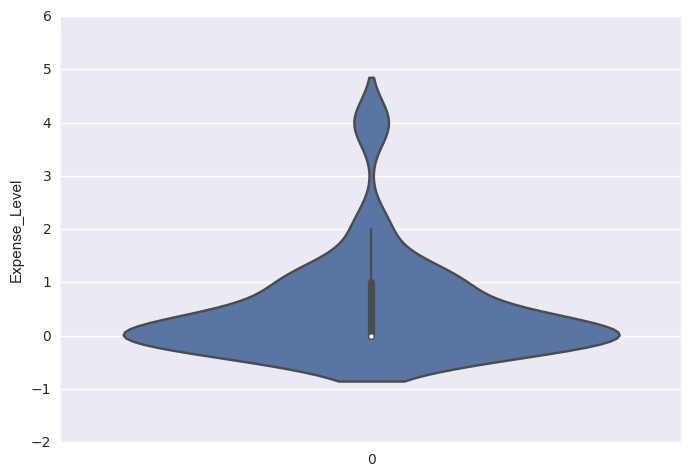

In [57]:
import seaborn
seaborn.violinplot(Predictor.predict(X_test),y_test )

#### Insight Drawn:
* Violin Plot above shows that my model is great at predicting small-time "0" Expense-Level type purchases but unable to predict anything beyond that.

### Testing against "NULL ACCURACY", the classifier we have to "Out-Perform"
* Null accuracy is the accuracy that could be achieved by always predicting the most frequent class. It is a baseline against which you may want to measure your classifier.

In [58]:
# How accurate is the DummyClassifier on my data?
# (Hopefully it was better than your favourite predictor)

# import the sklearn.dummy library
import sklearn.dummy

from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')

dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print sklearn.metrics.accuracy_score(y_test, y_dumb_class)

0.677419354839


#### Observation: 
* My "75% Training-25% Test" model and the "NULL ACCURACY" classifier have equal ACCURACY SCORES! Need to adjust my train-test split - this time, reduce Training Size to 50% and Test Size to 50%.

In [59]:
# Splitting the data into 50% Training and 50% Testing sets using train_test_split:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.5)

# Training a Logistic Reg Predictor on the Training Data
Predictor = sklearn.linear_model.LogisticRegression(C=10000000)
Predictor.fit(X_train, y_train)
Y_predict = Predictor.predict(X_test)

# Comparing the accuracy score between y_test (teacher's answer) vs Y_predict (my answer)
print sklearn.metrics.accuracy_score(y_test, Y_predict)

0.741935483871


In [60]:
# "Null Accuracy" Test against the 50% Train-50% Test Model
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print sklearn.metrics.accuracy_score(y_test, y_dumb_class)

0.741935483871


#### Observation: 
* My "50% Training-50% Test" model has worse accuracy score than "NULL ACCURACY"- now reducing my train size to 40% and test size to 60%.

In [61]:
# Splitting the data into 40% Training and 60% Testing sets using train_test_split:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.60)

# Training a Logistic Reg Predictor on the Training Data
Predictor = sklearn.linear_model.LogisticRegression(C=1000000)
Predictor.fit(X_train, y_train)
Y_predict = Predictor.predict(X_test)

# Comparing the accuracy score between y_test (teacher's answer) vs Y_predict (my answer)
print sklearn.metrics.accuracy_score(y_test, Y_predict)

0.711409395973


In [62]:
# "Null Accuracy" Test against the 40% Train-60% Test Model
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print sklearn.metrics.accuracy_score(y_test, y_dumb_class)

0.738255033557


#### Observation: 
* My "40% Training-60% Test" model has worse accuracy score than "NULL ACCURACY"- now using loops to find that "sweet spot"..

In [63]:
# Testing for test split values from 5% (i=1) to 95% (i=19).

my_scores = []
null_scores = []
for i in range(1, 20):
    j=i*0.05
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=j)
    Predictor = sklearn.linear_model.LogisticRegression(C=1000000)
    Predictor.fit(X_train, y_train)
    Y_predict = Predictor.predict(X_test)
    my_scores.append(sklearn.metrics.accuracy_score(y_test, Y_predict))
    
    dumb.fit(X_train, y_train)
    y_dumb_class = dumb.predict(X_test)
    null_scores.append(sklearn.metrics.accuracy_score(y_test, y_dumb_class))
print my_scores
print null_scores

[0.84615384615384615, 0.92000000000000004, 0.73684210526315785, 0.83999999999999997, 0.77419354838709675, 0.73333333333333328, 0.7816091954022989, 0.72999999999999998, 0.7232142857142857, 0.69354838709677424, 0.74452554744525545, 0.6912751677852349, 0.66049382716049387, 0.72413793103448276, 0.68279569892473113, 0.69346733668341709, 0.7345971563981043, 0.5714285714285714, 0.46610169491525422]
[0.84615384615384615, 0.92000000000000004, 0.73684210526315785, 0.83999999999999997, 0.77419354838709675, 0.73333333333333328, 0.7816091954022989, 0.77000000000000002, 0.7678571428571429, 0.69354838709677424, 0.76642335766423353, 0.71812080536912748, 0.77160493827160492, 0.74712643678160917, 0.73118279569892475, 0.75879396984924619, 0.7345971563981043, 0.7723214285714286, 0.75423728813559321]


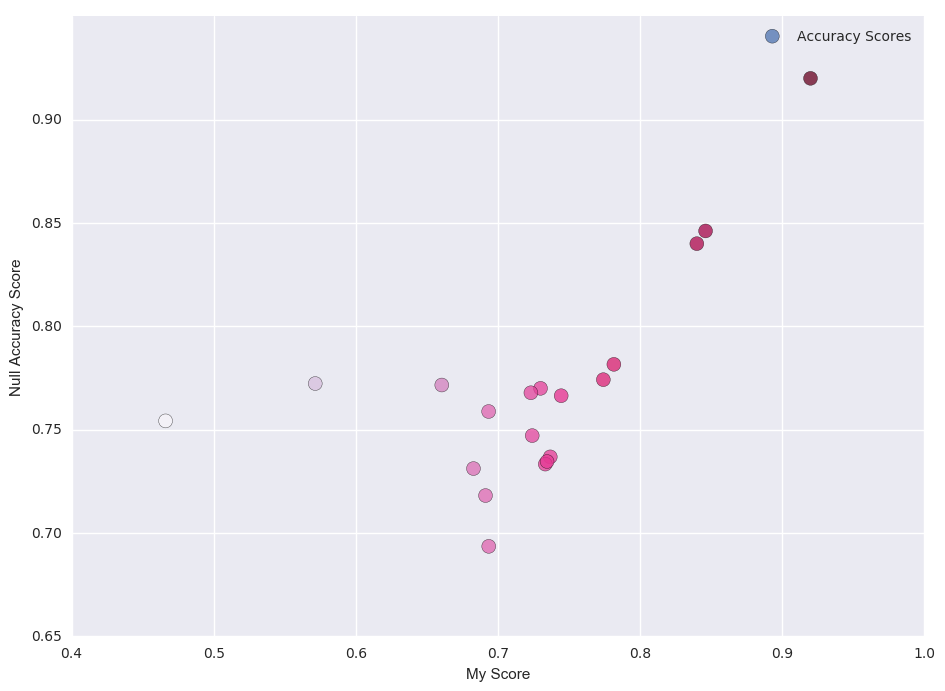

In [64]:
#plotting to compare my_scores vs null_scores
%matplotlib inline
import matplotlib
(fig,ax) = matplotlib.pyplot.subplots(figsize=(11, 8))
ax.scatter(my_scores, null_scores,s=100,
           cmap=matplotlib.pyplot.cm.PuRd,
           c=my_scores, alpha=0.75, label="Accuracy Scores")
ax.set_xlabel("My Score")
ax.set_ylabel("Null Accuracy Score")
ax.legend(loc='best')

#### Conclusion: I guess, the Null Accuracy model will always be at par with my model, if not slightly better. I guess, as far as the real life goes, it is better to be conservative and train with less data and test with more data; afterall, we will never see all the data that we need, at least during the model development timeframe. On the other end of the spectrum, settling for a 5% train -95% test split is probably too risky, because we are not giving the model enough samples to learn. Therefore, given this exhaustive information, I am picking the middle ground and sweet spot of  40% train and 60% test.